In [6]:
!pip install lifelines tqdm --quiet
# --- Repo + path setup ---

import os, sys

# 1) Clone repo if it doesn't exist
if not os.path.exists('/content/bdh_challenge_2025'):
    %cd /content
    !git clone https://github.com/arionandrei2000/bdh_challenge_2025.git

# 2) Move into repo root
%cd /content/bdh_challenge_2025
print("PWD:", os.getcwd())
print("Repo contents:", os.listdir())

# 3) src is under notebooks/src, so add that parent folder to sys.path
src_parent = "/content/bdh_challenge_2025/notebooks"
if src_parent not in sys.path:
    sys.path.append(src_parent)

print("sys.path updated; ready to import src.")


/content
Cloning into 'bdh_challenge_2025'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 117 (delta 20), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (117/117), 810.07 KiB | 6.98 MiB/s, done.
Resolving deltas: 100% (20/20), done.
/content/bdh_challenge_2025
PWD: /content/bdh_challenge_2025
Repo contents: ['README.md', '.git', 'notebooks']
sys.path updated; ready to import src.


In [8]:

# 02) Mount GDrive
# This lets us store large TCGA data in Drive so it persists across sessions

from google.colab import drive
drive.mount('/content/drive')

print(" Google Drive mounted at /content/drive")
# 03) Project Paths in Google Drive

from pathlib import Path
import os

# Main project root on Google Drive
PROJECT_ROOT = Path("/content/drive/MyDrive/bdh_challenge_2025_data")
PROJECT_ROOT.mkdir(exist_ok=True)

# Data directories

# Generic data directory
DATA_DIR = PROJECT_ROOT / "data"
DATA_DIR.mkdir(exist_ok=True)

# Directory where raw TCGA STAR count files will be stored
RNA_DIR = PROJECT_ROOT / "tcga_rna"
RNA_DIR.mkdir(exist_ok=True)

# Directory where processed matrices, tokenized data, embeddings
PROCESSED_DIR = PROJECT_ROOT / "processed"
PROCESSED_DIR.mkdir(exist_ok=True)

print("Project root :", PROJECT_ROOT)
print("DATA_DIR     :", DATA_DIR)
print("RNA_DIR      :", RNA_DIR)
print("PROCESSED_DIR:", PROCESSED_DIR)




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Google Drive mounted at /content/drive
Project root : /content/drive/MyDrive/bdh_challenge_2025_data
DATA_DIR     : /content/drive/MyDrive/bdh_challenge_2025_data/data
RNA_DIR      : /content/drive/MyDrive/bdh_challenge_2025_data/tcga_rna
PROCESSED_DIR: /content/drive/MyDrive/bdh_challenge_2025_data/processed


In [34]:
import os
from pathlib import Path

import numpy as np
import pandas as pd

from tqdm import tqdm

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.decomposition import PCA, NMF
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report
)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from lifelines.utils import concordance_index
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.decomposition import NMF
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA as PCA_sklearn  # avoid name clash
import matplotlib.pyplot as plt
import seaborn as sns



In [12]:
from pathlib import Path
import json
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

from lifelines import CoxPHFitter
from IPython.display import display

# 0) Paths

PROJECT_ROOT  = Path("/content/drive/MyDrive/bdh_challenge_2025_data")
PROCESSED_DIR = PROJECT_ROOT / "processed"

EXPR_FILE = PROCESSED_DIR / "tcga_tpm_like_log10_bulkrnabert_aligned.parquet"
CLIN_FILE = PROCESSED_DIR / "tcga_clinical_bulkrnabert_cohorts.parquet"

RANDOM_SEED = 1234

# 1) Load + align expression + clinical

expr = pd.read_parquet(EXPR_FILE)
clinical = pd.read_parquet(CLIN_FILE)

expr.index.name = "sample_id"
clinical.index.name = "sample_id"

common = expr.index.intersection(clinical.index)
expr = expr.loc[common].sort_index()
clinical = clinical.loc[common].sort_index()

print("Expression:", expr.shape)
print("Clinical  :", clinical.shape)

# 2) Build 5-cohort label mapping

five_map = {
    "BRCA": "BRCA",
    "BLCA": "BLCA",
    "LUAD": "LUAD",
    "UCEC": "UCEC",
    "GBM":  "GBMLGG",
    "LGG":  "GBMLGG",
}

clinical["cohort_5"] = clinical["cohort"].map(five_map)
df_5 = clinical.dropna(subset=["cohort_5"]).copy()
df_5["cohort_5"] = df_5["cohort_5"].astype("category")
df_5["cohort_5_idx"] = df_5["cohort_5"].cat.codes

expr_5 = expr.loc[df_5.index]

print("\n--- 5-cohort counts ---")
print(df_5["cohort_5"].value_counts())

# 3) Survival subset (pan-cancer)


surv_df = clinical.dropna(subset=["survival_time", "event"]).copy()
expr_surv = expr.loc[surv_df.index]

print("\nSurvival subset shape:", expr_surv.shape)

# 4) Helper: save splits as JSON

def save_split(path, **arrays):
    payload = {k: list(v) for k, v in arrays.items()}
    with open(path, "w") as f:
        json.dump(payload, f)

# 5) Create + save splits

# 5-cohort split (stratified)
train_5, test_5 = train_test_split(
    df_5.index.to_numpy(),
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=df_5["cohort_5"]
)
save_split(PROCESSED_DIR / "splits_5cohort.json",
           train_ids=train_5, test_ids=test_5)

# Pan-cancer classification split (all cohorts)
train_pan, test_pan = train_test_split(
    clinical.index.to_numpy(),
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=clinical["cohort"]
)
save_split(PROCESSED_DIR / "splits_pancancer.json",
           train_ids=train_pan, test_ids=test_pan)

# Pan-cancer survival split (no stratify)
train_surv, test_surv = train_test_split(
    surv_df.index.to_numpy(),
    test_size=0.2,
    random_state=RANDOM_SEED,
)
save_split(PROCESSED_DIR / "splits_survival_pancancer.json",
           train_ids=train_surv, test_ids=test_surv)

print("\nSaved splits:")
for p in PROCESSED_DIR.glob("splits_*.json"):
    print(" •", p.name)

# 6) Helper to load splits + build X/y

def load_split(path: Path):
    with open(path) as f:
        d = json.load(f)
    return np.array(d["train_ids"]), np.array(d["test_ids"])


def get_Xy(expr_df, label_series, train_ids, test_ids):
    X_train = expr_df.loc[train_ids].values
    y_train = label_series.loc[train_ids].values

    X_test = expr_df.loc[test_ids].values
    y_test = label_series.loc[test_ids].values

    return X_train, y_train, X_test, y_test



Expression: (3385, 19062)
Clinical  : (3385, 12)

--- 5-cohort counts ---
cohort_5
BRCA      1095
GBMLGG     809
UCEC       557
LUAD       518
BLCA       406
Name: count, dtype: int64

Survival subset shape: (3351, 19062)

Saved splits:
 • splits_5cohort.json
 • splits_pancancer.json
 • splits_survival_pancancer.json



 Running 5-cohort PCA+SVM

--- 5-cohort metrics ---
Accuracy   : 0.9940915805022157
Macro F1   : 0.992906474859365
Weighted F1: 0.9940961657501629

Classification report:
              precision    recall  f1-score   support

        BLCA       0.98      1.00      0.99        81
        BRCA       1.00      1.00      1.00       219
      GBMLGG       1.00      1.00      1.00       162
        LUAD       0.99      0.99      0.99       104
        UCEC       1.00      0.98      0.99       111

    accuracy                           0.99       677
   macro avg       0.99      0.99      0.99       677
weighted avg       0.99      0.99      0.99       677


Metrics summary table:


,Accuracy,Macro F1,Weighted F1
PCA(256) + SVM (5 cohorts),0.994092,0.992906,0.994096


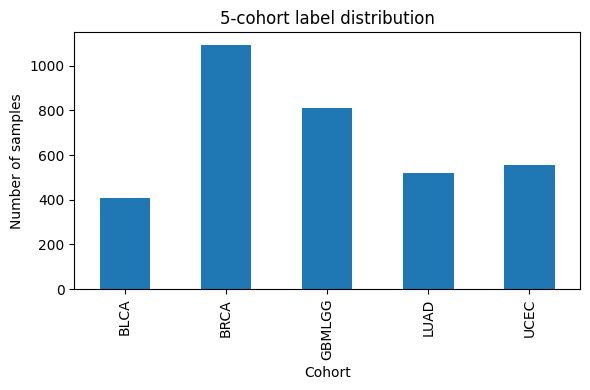

<Figure size 500x500 with 0 Axes>

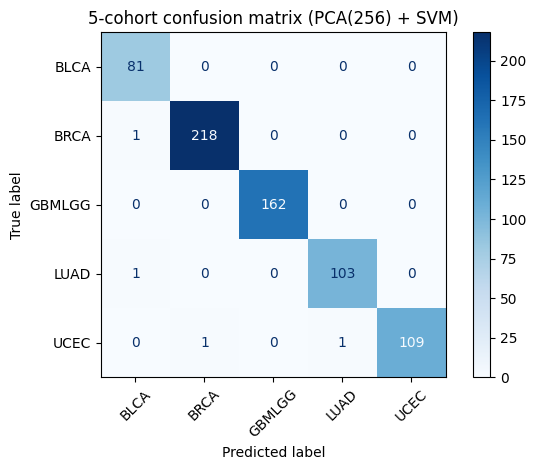


Computing 2D PCA projection for visualization...


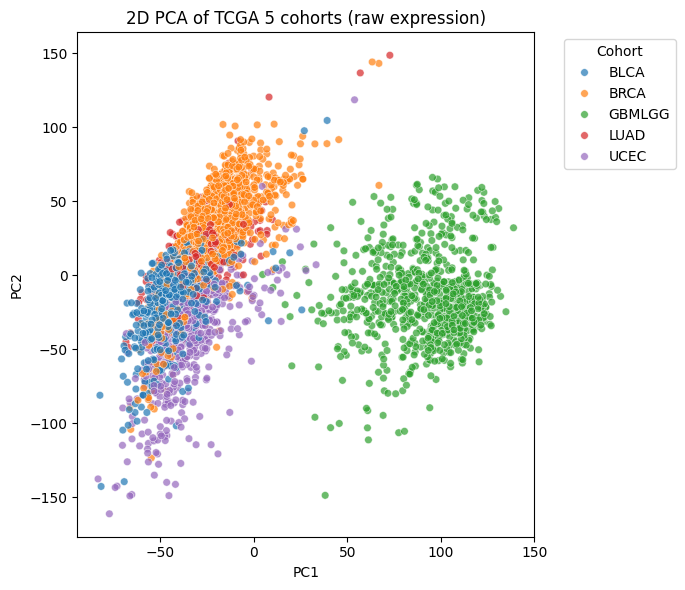

In [31]:

# 7) 5-cohort PCA + SVM baseline

print("\n Running 5-cohort PCA+SVM")
split_5_path = PROCESSED_DIR / "splits_5cohort.json"
train_ids_5, test_ids_5 = load_split(split_5_path)

train_ids_5 = np.array([s for s in train_ids_5 if s in expr_5.index])
test_ids_5  = np.array([s for s in test_ids_5  if s in expr_5.index])

X_train_5, y_train_5, X_test_5, y_test_5 = get_Xy(
    expr_5, df_5["cohort_5"], train_ids_5, test_ids_5
)

clf_5 = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=256, random_state=1234)),
    ("svm", SVC(
        kernel="rbf",
        C=10.0,
        gamma="scale",
        class_weight="balanced",
        random_state=1234,
    ))
])

clf_5.fit(X_train_5, y_train_5)
y_pred_5 = clf_5.predict(X_test_5)

# ---------------------------------------------------------------------
# 7.3 Metrics + classification report
# ---------------------------------------------------------------------
acc_5        = accuracy_score(y_test_5, y_pred_5)
macro_f1_5   = f1_score(y_test_5, y_pred_5, average="macro")
weighted_f1_5= f1_score(y_test_5, y_pred_5, average="weighted")

print("\n--- 5-cohort metrics ---")
print("Accuracy   :", acc_5)
print("Macro F1   :", macro_f1_5)
print("Weighted F1:", weighted_f1_5)

print("\nClassification report:")
print(classification_report(y_test_5, y_pred_5))

# Nice compact metrics summary table (useful for the BDH report)
metrics_5 = pd.DataFrame(
    {
        "Accuracy":   [acc_5],
        "Macro F1":   [macro_f1_5],
        "Weighted F1":[weighted_f1_5],
    },
    index=["PCA(256) + SVM (5 cohorts)"],
)
print("\nMetrics summary table:")
display(metrics_5)

# ---------------------------------------------------------------------
# 7.4 Label distribution plot (matches the style of Figure 5 in paper)
# ---------------------------------------------------------------------
plt.figure(figsize=(6,4))
df_5["cohort_5"].value_counts().sort_index().plot(kind="bar")
plt.title("5-cohort label distribution")
plt.xlabel("Cohort")
plt.ylabel("Number of samples")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 7.5 Confusion matrix for PCA+SVM baseline
# ---------------------------------------------------------------------
cm = confusion_matrix(y_test_5, y_pred_5, labels=np.unique(y_test_5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test_5))

plt.figure(figsize=(5,5))
disp.plot(cmap="Blues", values_format="d")
plt.title("5-cohort confusion matrix (PCA(256) + SVM)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 7.6 2D PCA visualization of raw expression (sanity check / nice figure)
#     This is *just* for visualization; not used in the SVM pipeline.
# ---------------------------------------------------------------------
print("\nComputing 2D PCA projection for visualization...")

scaler_vis = StandardScaler()
X_scaled_5 = scaler_vis.fit_transform(expr_5.loc[df_5.index])  # all 5 cohorts

pca_vis = PCA(n_components=2, random_state=1234)
X_pca_2 = pca_vis.fit_transform(X_scaled_5)

pca_vis_df = pd.DataFrame(
    {
        "PC1": X_pca_2[:, 0],
        "PC2": X_pca_2[:, 1],
        "cohort_5": df_5["cohort_5"].values,
    },
    index=df_5.index,
)

plt.figure(figsize=(7,6))
sns.scatterplot(
    data=pca_vis_df,
    x="PC1",
    y="PC2",
    hue="cohort_5",
    alpha=0.7,
    s=30,
)
plt.title("2D PCA of TCGA 5 cohorts (raw expression)")
plt.legend(title="Cohort", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


 Running 5-cohort NMF+SVM baseline

5-cohort NMF+SVM metrics
Accuracy   : 0.9512555391432792
Macro F1   : 0.9418294193588942
Weighted F1: 0.951557712644224


,Accuracy,Macro F1,Weighted F1
NMF(64) + SVM (5 cohorts),0.951256,0.941829,0.951558


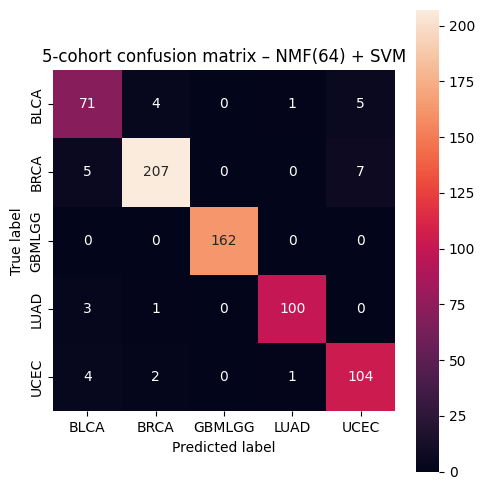

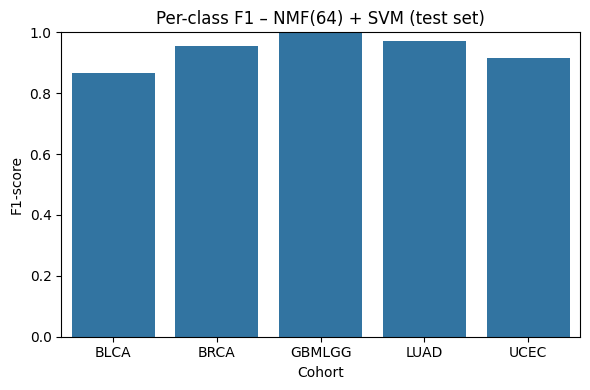


Computing 2D PCA on NMF latent space for visualization...


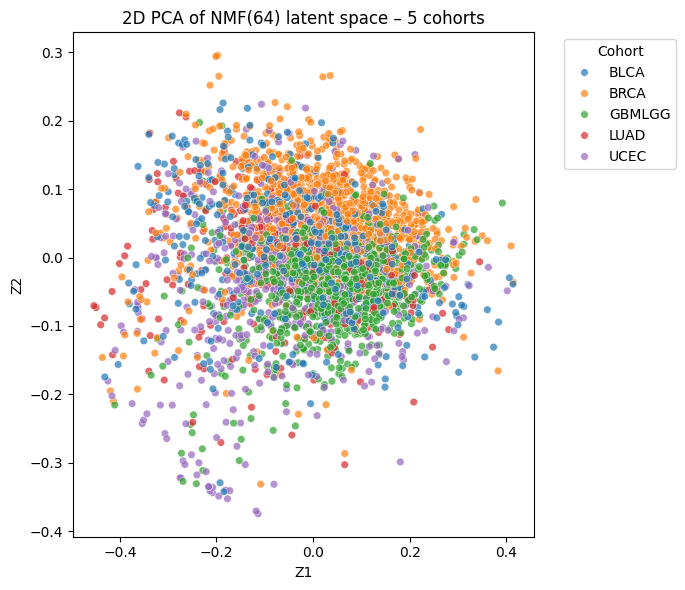


Computing UMAP on NMF latent space...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


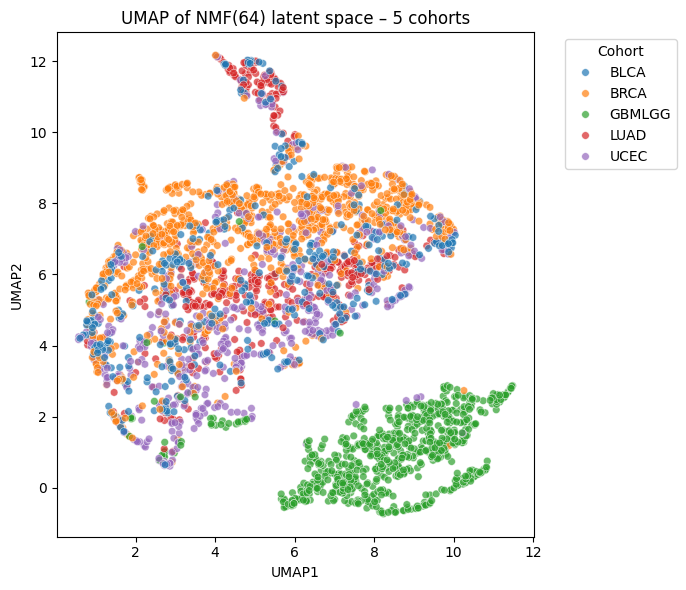

In [50]:

# 8) 5-cohort NMF + SVM baseline (classification)


from sklearn.decomposition import NMF

print("\n Running 5-cohort NMF+SVM baseline")


clf_5_nmf = Pipeline([
    ("nmf", NMF(
        n_components=64,
        init="nndsvda",
        random_state=RANDOM_SEED,
        max_iter=400,
        tol=1e-3,
    )),
    ("svm", SVC(
        kernel="rbf",
        C=10.0,
        gamma="scale",
        class_weight="balanced",
        random_state=RANDOM_SEED,
    )),
])

# Fit on training data with proper labels
clf_5_nmf.fit(X_train_5, y_train_5)
y_pred_5_nmf = clf_5_nmf.predict(X_test_5)

acc_5_nmf         = accuracy_score(y_test_5, y_pred_5_nmf)
macro_f1_5_nmf    = f1_score(y_test_5, y_pred_5_nmf, average="macro")
weighted_f1_5_nmf = f1_score(y_test_5, y_pred_5_nmf, average="weighted")

print("\n5-cohort NMF+SVM metrics")
print("Accuracy   :", acc_5_nmf)
print("Macro F1   :", macro_f1_5_nmf)
print("Weighted F1:", weighted_f1_5_nmf)

metrics_5_nmf = pd.DataFrame(
    {
        "Accuracy":   [acc_5_nmf],
        "Macro F1":   [macro_f1_5_nmf],
        "Weighted F1":[weighted_f1_5_nmf],
    },
    index=["NMF(64) + SVM (5 cohorts)"],
)
display(metrics_5_nmf)

# ---------------------------------------------------------------------
# 8.1 Confusion matrix for NMF+SVM
# ---------------------------------------------------------------------

labels_5 = np.unique(y_test_5)
cm_nmf = confusion_matrix(y_test_5, y_pred_5_nmf, labels=labels_5)

plt.figure(figsize=(5,5))
sns.heatmap(
    cm_nmf,
    annot=True,
    fmt="d",
    xticklabels=labels_5,
    yticklabels=labels_5,
    square=True,
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("5-cohort confusion matrix – NMF(64) + SVM")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 8.2 Per-class F1 scores (bar plot)
# ---------------------------------------------------------------------

cr_nmf = classification_report(
    y_test_5,
    y_pred_5_nmf,
    output_dict=True,
    zero_division=0,
)

# Turn into DataFrame and keep only the cohort labels (drop 'accuracy', 'macro avg', 'weighted avg')
cr_df = pd.DataFrame(cr_nmf).T
cr_df = cr_df.loc[labels_5]  # ordered by label

plt.figure(figsize=(6,4))
sns.barplot(
    x=cr_df.index,
    y=cr_df["f1-score"].values,
)
plt.ylim(0, 1.0)
plt.ylabel("F1-score")
plt.xlabel("Cohort")
plt.title("Per-class F1 – NMF(64) + SVM (test set)")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 8.3 2D visualization of NMF latent space (all 5 cohorts)
#     NMF(64) -> PCA(2) -> scatter colored by cohort_5
# ---------------------------------------------------------------------

print("\nComputing 2D PCA on NMF latent space for visualization...")

# Get fitted NMF step and project all 5-cohort samples
nmf_step = clf_5_nmf.named_steps["nmf"]

# Use the same gene subset as X_train_5 / X_test_5
# (X_train_5 came from expr_5.loc[train_ids_5])
X_all_5 = expr_5.loc[df_5.index].values
Z_all_5 = nmf_step.transform(X_all_5)  # shape: (n_samples, 64)

pca_latent = PCA_sklearn(n_components=2, random_state=RANDOM_SEED)
Z_2d = pca_latent.fit_transform(Z_all_5)

latent_df = pd.DataFrame(
    {
        "Z1": Z_2d[:, 0],
        "Z2": Z_2d[:, 1],
        "cohort_5": df_5["cohort_5"].values,
    },
    index=df_5.index,
)

plt.figure(figsize=(7,6))
sns.scatterplot(
    data=latent_df,
    x="Z1",
    y="Z2",
    hue="cohort_5",
    alpha=0.7,
    s=30,
)
plt.title("2D PCA of NMF(64) latent space – 5 cohorts")
plt.legend(title="Cohort", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


# 8.6 UMAP visualization of NMF(64) latent space

!pip install -q umap-learn

import umap

print("\nComputing UMAP on NMF latent space...")

# If you're in the same session as 8.3:
#   - nmf_step = clf_5_nmf.named_steps["nmf"]
#   - X_all_5 = expr_5.loc[df_5.index].values
#   - Z_all_5 = nmf_step.transform(X_all_5)

reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric="euclidean",
    random_state=RANDOM_SEED,
)

Z_umap = reducer.fit_transform(Z_all_5)  # shape: (n_samples, 2)

umap_df = pd.DataFrame(
    {
        "UMAP1": Z_umap[:, 0],
        "UMAP2": Z_umap[:, 1],
        "cohort_5": df_5["cohort_5"].values,
    },
    index=df_5.index,
)

plt.figure(figsize=(7,6))
sns.scatterplot(
    data=umap_df,
    x="UMAP1",
    y="UMAP2",
    hue="cohort_5",
    alpha=0.7,
    s=30,
)
plt.title("UMAP of NMF(64) latent space – 5 cohorts")
plt.legend(title="Cohort", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()




Building cohort-mean NMF component heatmap...


/tmp/ipython-input-3080722572.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("cohort_5")


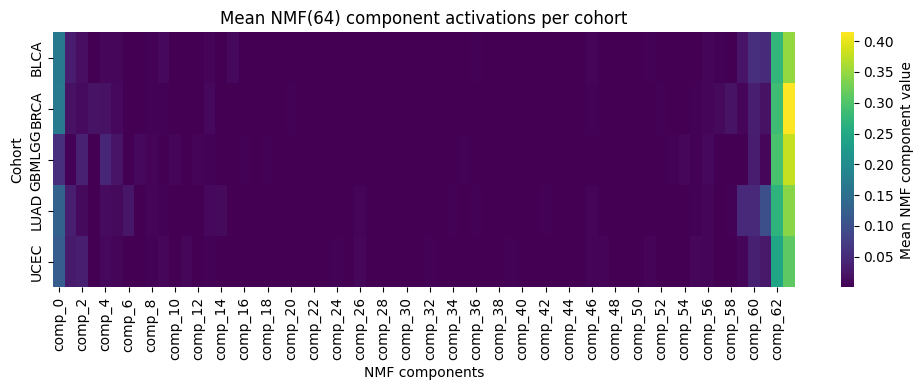


Top 10 genes for component 63:
01. ENSG00000071794  (weight=1.5131)
02. ENSG00000102908  (weight=1.4915)
03. ENSG00000008710  (weight=1.4685)
04. ENSG00000114554  (weight=1.4608)
05. ENSG00000007080  (weight=1.4332)
06. ENSG00000133265  (weight=1.4235)
07. ENSG00000125503  (weight=1.4183)
08. ENSG00000166925  (weight=1.4074)
09. ENSG00000064393  (weight=1.4062)
10. ENSG00000115464  (weight=1.3853)

Top 10 genes for component 62:
01. ENSG00000156508  (weight=3.3960)
02. ENSG00000184009  (weight=3.1159)
03. ENSG00000096384  (weight=3.0916)
04. ENSG00000109971  (weight=2.9032)
05. ENSG00000080824  (weight=2.8456)
06. ENSG00000167658  (weight=2.8035)
07. ENSG00000100316  (weight=2.7616)
08. ENSG00000089157  (weight=2.7527)
09. ENSG00000174444  (weight=2.7207)
10. ENSG00000009307  (weight=2.6842)

Top 10 genes for component 61:
01. ENSG00000151632  (weight=6.3340)
02. ENSG00000187134  (weight=5.6366)
03. ENSG00000198074  (weight=4.5225)
04. ENSG00000176153  (weight=4.4538)
05. ENSG00000196

In [42]:
# ---------------------------------------------------------------------
# 8.4 Heatmap of mean NMF components per cohort
# ---------------------------------------------------------------------

print("\nBuilding cohort-mean NMF component heatmap...")

# Z_all_5 already computed above: shape (n_samples, 64)
Z_all_5_df = pd.DataFrame(
    Z_all_5,
    index=df_5.index,
    columns=[f"comp_{i}" for i in range(Z_all_5.shape[1])],
)

# Attach cohort labels
Z_all_5_df["cohort_5"] = df_5["cohort_5"]

# Compute mean activation of each component per cohort
cohort_means = (
    Z_all_5_df
    .groupby("cohort_5")
    .mean()
    .drop(columns=[], errors="ignore")  # just in case
)

plt.figure(figsize=(10, 4))
sns.heatmap(
    cohort_means,
    annot=False,
    cmap="viridis",
    cbar_kws={"label": "Mean NMF component value"},
)
plt.title("Mean NMF(64) component activations per cohort")
plt.xlabel("NMF components")
plt.ylabel("Cohort")
plt.tight_layout()
plt.show()

nmf_step = clf_5_nmf.named_steps["nmf"]
components = nmf_step.components_   # shape (64 × n_genes)

genes = expr_5.columns.to_numpy()

for comp in [63, 62, 61,0]:
    print(f"\nTop 10 genes for component {comp}:")
    comp_weights = components[comp]
    top_idx = np.argsort(comp_weights)[::-1][:10]

    for rank, gi in enumerate(top_idx, start=1):
        print(f"{rank:02d}. {genes[gi]}  (weight={comp_weights[gi]:.4f})")


In [47]:
# Map Ensembl → Gene symbol using Ensembl BioMart
!pip install -q mygene

import mygene
mg = mygene.MyGeneInfo()

def ensg_to_symbol(ensg_list):
    out = mg.querymany(
        ensg_list,
        scopes='ensembl.gene',
        fields='symbol,name',
        species='human'
    )
    mapping = {}
    for item in out:
        if 'symbol' in item:
            mapping[item['query']] = item['symbol']
        else:
            mapping[item['query']] = None
    return mapping
ensg63 = ensg_to_symbol([
    "ENSG00000071794","ENSG00000102908","ENSG00000008710","ENSG00000114554",
    "ENSG00000007080","ENSG00000133265","ENSG00000125503","ENSG00000166925",
    "ENSG00000064393","ENSG00000115464"
])

ensg62 = ensg_to_symbol([
    "ENSG00000156508","ENSG00000184009","ENSG00000096384","ENSG00000109971",
    "ENSG00000080824","ENSG00000167658","ENSG00000100316","ENSG00000089157",
    "ENSG00000174444","ENSG00000009307"
])

ensg61 = ensg_to_symbol([
    "ENSG00000151632","ENSG00000187134","ENSG00000198074","ENSG00000176153",
    "ENSG00000196139","ENSG00000198848","ENSG00000108602","ENSG00000181019",
    "ENSG00000171903","ENSG00000140961"
])

ensg0 = ensg_to_symbol([
    "ENSG00000156508","ENSG00000184009","ENSG00000096384","ENSG00000089157",
    "ENSG00000100316","ENSG00000080824","ENSG00000167658","ENSG00000137154",
    "ENSG00000174444","ENSG00000148303"
])

print("Component 63:", ensg63)
print("Component 62:", ensg62)
print("Component 61:", ensg61)
print("Component 0:", ensg0)

INFO:biothings.client:querying 1-10 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-10 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-10 ...
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-10 ...
INFO:biothings.client:Finished.


Component 63: {'ENSG00000071794': 'HLTF', 'ENSG00000102908': 'NFAT5', 'ENSG00000008710': 'PKD1', 'ENSG00000114554': 'PLXNA1', 'ENSG00000007080': 'CCDC124', 'ENSG00000133265': 'HSPBP1', 'ENSG00000125503': 'PPP1R12C', 'ENSG00000166925': 'TSC22D4', 'ENSG00000064393': 'HIPK2', 'ENSG00000115464': 'USP34'}
Component 62: {'ENSG00000156508': 'EEF1A1', 'ENSG00000184009': 'ACTG1', 'ENSG00000096384': 'HSP90AB1', 'ENSG00000109971': 'HSPA8', 'ENSG00000080824': 'HSP90AA1', 'ENSG00000167658': 'EEF2', 'ENSG00000100316': 'RPL3', 'ENSG00000089157': 'RPLP0', 'ENSG00000174444': 'RPL4', 'ENSG00000009307': 'CSDE1'}
Component 61: {'ENSG00000151632': 'AKR1C2', 'ENSG00000187134': 'AKR1C1', 'ENSG00000198074': 'AKR1B10', 'ENSG00000176153': 'GPX2', 'ENSG00000196139': 'AKR1C3', 'ENSG00000198848': 'CES1', 'ENSG00000108602': 'ALDH3A1', 'ENSG00000181019': 'NQO1', 'ENSG00000171903': 'CYP4F11', 'ENSG00000140961': 'OSGIN1'}
Component 0: {'ENSG00000156508': 'EEF1A1', 'ENSG00000184009': 'ACTG1', 'ENSG00000096384': 'HSP90A

NMF revealed that each TCGA cohort expresseD a distinct combination of latent transcriptomic programs which enabled the clear separation of BRCA, BLCA, LUAD, UCEC, and GBMLGG. A stress-response and DNA-damage module in Component 63, enriched for genes such as HLTF, HIPK2, NFAT5, and USP34, was strongly activated in genomically unstable tumors like basal-type BRCA and BLCA. A xenobiotic-metabolism axis in Component 61, dominated by AKR1C1/2/3, ALDH3A1, NQO1, and CES1, distinguished LUAD and BLCA and reflects detoxification processes associated with environmental or chemical exposures. Conversely, translation and ribosome-associated programs Components 0 and 62, enriched for EEF1A1, EEF2, HSP90AA1/AB1, and RPL family genes, were characteristic of proliferative tumors such as UCEC and subsets of BRCA. GBMLGG formed its own cluster due to strong glial-lineage programs and minimal activation of detox or stress components.

These findings are not just computationally interesting, they are alose important biologically. I currently work in Biotech field where transcriptomic profiling is the first step in understanding mechanism of action or potential gene targets, this result demonstrates how unsupervised NMF could potentially uncover mechanistically relevant programs directly from bulk RNA-seq


=== Running Pan-6 PCA+SVM baseline (6 TCGA cohorts) ===
Pan-6 train shape: (2708, 19062)
Pan-6 test  shape: (677, 19062)
Unique cohorts in y_train: ['BLCA' 'BRCA' 'GBM' 'LGG' 'LUAD' 'UCEC']

--- Pan-6 PCA+SVM metrics ---
Accuracy   : 0.9940915805022157
Macro F1   : 0.9927850215954886
Weighted F1: 0.9941058310768675

Classification report (Pan-6, PCA+SVM):
              precision    recall  f1-score   support

        BLCA       0.98      0.99      0.98        81
        BRCA       1.00      1.00      1.00       219
         GBM       0.98      1.00      0.99        59
         LGG       1.00      0.99      1.00       103
        LUAD       1.00      0.99      1.00       104
        UCEC       0.99      1.00      1.00       111

    accuracy                           0.99       677
   macro avg       0.99      0.99      0.99       677
weighted avg       0.99      0.99      0.99       677


Pan-6 PCA+SVM metrics summary table:


,Accuracy,Macro F1,Weighted F1
PCA(256) + SVM (Pan-6 cohorts),0.994092,0.992785,0.994106


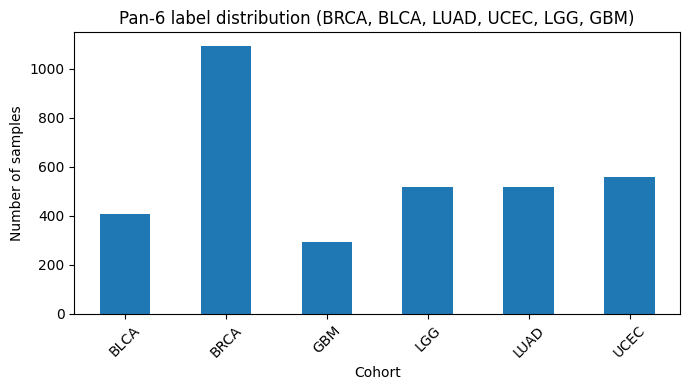

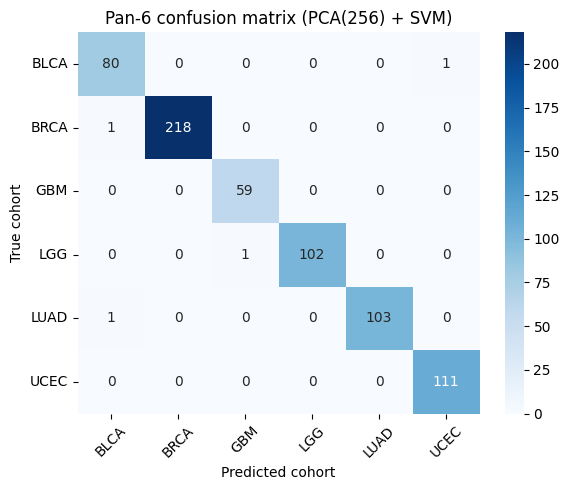

In [48]:
# 8) "Pan-6" PCA + SVM baseline (6 cohorts: BRCA, BLCA, LUAD, UCEC, LGG, GBM)

print("\n=== Running Pan-6 PCA+SVM baseline (6 TCGA cohorts) ===")

split_pan_path = PROCESSED_DIR / "splits_pancancer.json"
train_ids_pan, test_ids_pan = load_split(split_pan_path)

# Make sure IDs exist in the expression matrix
train_ids_pan = np.array([s for s in train_ids_pan if s in expr.index])
test_ids_pan  = np.array([s for s in test_ids_pan  if s in expr.index])

# Build X/y using the original cohort labels (6 cancer types)
X_train_pan, y_train_pan, X_test_pan, y_test_pan = get_Xy(
    expr, clinical["cohort"], train_ids_pan, test_ids_pan
)

print("Pan-6 train shape:", X_train_pan.shape)
print("Pan-6 test  shape:", X_test_pan.shape)
print("Unique cohorts in y_train:", np.unique(y_train_pan))

clf_pan_pca = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=256, random_state=RANDOM_SEED)),
    ("svm", SVC(
        kernel="rbf",
        C=10.0,
        gamma="scale",
        class_weight="balanced",
        random_state=RANDOM_SEED,
    )),
])

clf_pan_pca.fit(X_train_pan, y_train_pan)
y_pred_pan_pca = clf_pan_pca.predict(X_test_pan)

# Metrics
acc_pan_pca         = accuracy_score(y_test_pan, y_pred_pan_pca)
macro_f1_pan_pca    = f1_score(y_test_pan, y_pred_pan_pca, average="macro")
weighted_f1_pan_pca = f1_score(y_test_pan, y_pred_pan_pca, average="weighted")

print("\n--- Pan-6 PCA+SVM metrics ---")
print("Accuracy   :", acc_pan_pca)
print("Macro F1   :", macro_f1_pan_pca)
print("Weighted F1:", weighted_f1_pan_pca)

print("\nClassification report (Pan-6, PCA+SVM):")
print(classification_report(y_test_pan, y_pred_pan_pca))

metrics_pan_pca = pd.DataFrame(
    {
        "Accuracy":   [acc_pan_pca],
        "Macro F1":   [macro_f1_pan_pca],
        "Weighted F1":[weighted_f1_pan_pca],
    },
    index=["PCA(256) + SVM (Pan-6 cohorts)"],
)
print("\nPan-6 PCA+SVM metrics summary table:")
display(metrics_pan_pca)

# Label distribution for the 6 cohorts
plt.figure(figsize=(7, 4))
clinical["cohort"].value_counts().sort_index().plot(kind="bar")
plt.title("Pan-6 label distribution (BRCA, BLCA, LUAD, UCEC, LGG, GBM)")
plt.xlabel("Cohort")
plt.ylabel("Number of samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Confusion matrix
labels_pan = np.unique(y_test_pan)
cm_pan_pca = confusion_matrix(y_test_pan, y_pred_pan_pca, labels=labels_pan)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_pan_pca,
    annot=True,
    fmt="d",
    xticklabels=labels_pan,
    yticklabels=labels_pan,
    cmap="Blues"
)
plt.xlabel("Predicted cohort")
plt.ylabel("True cohort")
plt.title("Pan-6 confusion matrix (PCA(256) + SVM)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



=== Running Pan-6 NMF+SVM baseline (6 TCGA cohorts) ===


/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(



--- Pan-6 NMF+SVM metrics ---
Accuracy   : 0.8877400295420975
Macro F1   : 0.8802126494038481
Weighted F1: 0.8895293487765246

Classification report (Pan-6, NMF+SVM):
              precision    recall  f1-score   support

        BLCA       0.77      0.91      0.84        81
        BRCA       0.99      0.86      0.92       219
         GBM       0.84      0.90      0.87        59
         LGG       0.94      0.90      0.92       103
        LUAD       0.81      0.88      0.84       104
        UCEC       0.87      0.91      0.89       111

    accuracy                           0.89       677
   macro avg       0.87      0.89      0.88       677
weighted avg       0.90      0.89      0.89       677


Pan-6 NMF+SVM metrics summary table:


,Accuracy,Macro F1,Weighted F1
NMF(64) + SVM (Pan-6 cohorts),0.88774,0.880213,0.889529


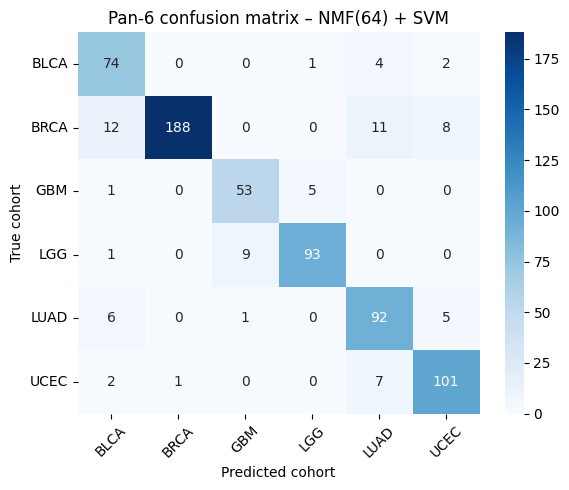


Computing 2D PCA on NMF latent space for Pan-6...


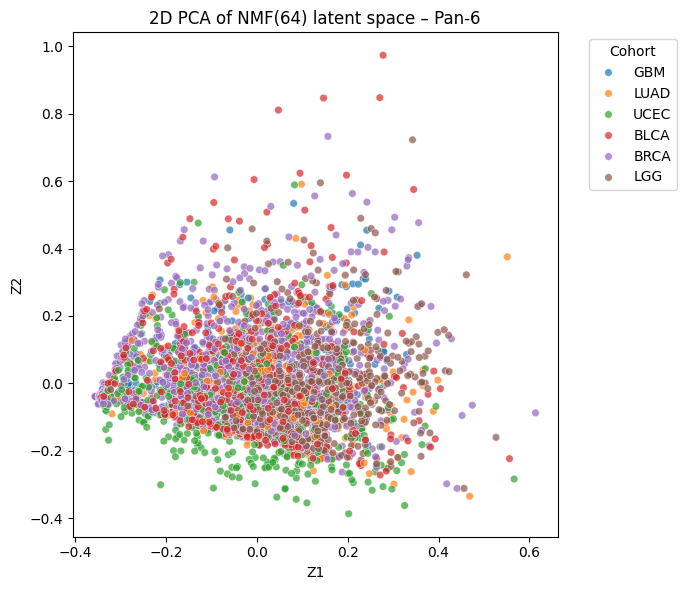

In [51]:
# 9) Pan-6 NMF + SVM baseline (6 cohorts)

print("\n Running Pan-6 NMF+SVM baseline (6 TCGA cohorts) ")

# Reuse X_train_pan, y_train_pan, X_test_pan, y_test_pan from previous cell

clf_pan_nmf = Pipeline([
    ("nmf", NMF(
        n_components=64,
        init="nndsvda",
        random_state=RANDOM_SEED,
        max_iter=400,
        tol=1e-3,
    )),
    ("svm", SVC(
        kernel="rbf",
        C=10.0,
        gamma="scale",
        class_weight="balanced",
        random_state=RANDOM_SEED,
    )),
])

clf_pan_nmf.fit(X_train_pan, y_train_pan)
y_pred_pan_nmf = clf_pan_nmf.predict(X_test_pan)

acc_pan_nmf         = accuracy_score(y_test_pan, y_pred_pan_nmf)
macro_f1_pan_nmf    = f1_score(y_test_pan, y_pred_pan_nmf, average="macro")
weighted_f1_pan_nmf = f1_score(y_test_pan, y_pred_pan_nmf, average="weighted")

print("\n Pan-6 NMF+SVM metrics ")
print("Accuracy   :", acc_pan_nmf)
print("Macro F1   :", macro_f1_pan_nmf)
print("Weighted F1:", weighted_f1_pan_nmf)

print("\nClassification report (Pan-6, NMF+SVM):")
print(classification_report(y_test_pan, y_pred_pan_nmf))

metrics_pan_nmf = pd.DataFrame(
    {
        "Accuracy":   [acc_pan_nmf],
        "Macro F1":   [macro_f1_pan_nmf],
        "Weighted F1":[weighted_f1_pan_nmf],
    },
    index=["NMF(64) + SVM (Pan-6 cohorts)"],
)
print("\nPan-6 NMF+SVM metrics summary table:")
display(metrics_pan_nmf)

# Confusion matrix
labels_pan = np.unique(y_test_pan)
cm_pan_nmf = confusion_matrix(y_test_pan, y_pred_pan_nmf, labels=labels_pan)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_pan_nmf,
    annot=True,
    fmt="d",
    xticklabels=labels_pan,
    yticklabels=labels_pan,
    cmap="Blues"
)
plt.xlabel("Predicted cohort")
plt.ylabel("True cohort")
plt.title("Pan-6 confusion matrix – NMF(64) + SVM")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 9.1 2D visualization of NMF latent space (Pan-6)
print("\nComputing 2D PCA on NMF latent space for Pan-6...")

nmf_pan = clf_pan_nmf.named_steps["nmf"]
X_all_pan = expr.loc[clinical.index].values  # all 6 cohorts
Z_all_pan = nmf_pan.transform(X_all_pan)     # (n_samples, 64)

pca_latent_pan = PCA_sklearn(n_components=2, random_state=RANDOM_SEED)
Z_pan_2d = pca_latent_pan.fit_transform(Z_all_pan)

latent_pan_df = pd.DataFrame(
    {
        "Z1": Z_pan_2d[:, 0],
        "Z2": Z_pan_2d[:, 1],
        "cohort": clinical["cohort"].values,
    },
    index=clinical.index,
)

plt.figure(figsize=(7, 6))
sns.scatterplot(
    data=latent_pan_df,
    x="Z1",
    y="Z2",
    hue="cohort",
    alpha=0.7,
    s=30,
)
plt.title("2D PCA of NMF(64) latent space – Pan-6")
plt.legend(title="Cohort", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()



In [73]:
# 10A) Pan-6 survival baseline: PCA(k) + CoxPH(penalized)

N_PCS = 6
PENALIZER = 0.1

print(f"\n=== Pan-6 Survival: PCA({N_PCS}) + CoxPH(penalizer={PENALIZER}) ===")

split_surv_path = PROCESSED_DIR / "splits_survival_pancancer.json"
train_ids_surv, test_ids_surv = load_split(split_surv_path)

train_ids_surv = np.array([s for s in train_ids_surv if s in expr_surv.index])
test_ids_surv  = np.array([s for s in test_ids_surv  if s in expr_surv.index])

X_train_surv = expr_surv.loc[train_ids_surv].values
X_test_surv  = expr_surv.loc[test_ids_surv].values

time_train  = surv_df.loc[train_ids_surv, "survival_time"].values
event_train = surv_df.loc[train_ids_surv, "event"].astype(int).values
time_test   = surv_df.loc[test_ids_surv, "survival_time"].values
event_test  = surv_df.loc[test_ids_surv, "event"].astype(int).values

print("Pan-6 survival train shape:", X_train_surv.shape)
print("Pan-6 survival test  shape:", X_test_surv.shape)

scaler_surv = StandardScaler()
X_train_scaled = scaler_surv.fit_transform(X_train_surv)
X_test_scaled  = scaler_surv.transform(X_test_surv)

pca_surv = PCA(n_components=N_PCS, random_state=RANDOM_SEED)
Z_train = pca_surv.fit_transform(X_train_scaled)
Z_test  = pca_surv.transform(X_test_scaled)

pc_cols = [f"PC{i+1}" for i in range(Z_train.shape[1])]

df_train_surv = pd.DataFrame(Z_train, index=train_ids_surv, columns=pc_cols)
df_train_surv["time"] = time_train
df_train_surv["event"] = event_train

df_test_surv = pd.DataFrame(Z_test, index=test_ids_surv, columns=pc_cols)
df_test_surv["time"] = time_test
df_test_surv["event"] = event_test

cph = CoxPHFitter(penalizer=PENALIZER)
cph.fit(df_train_surv, duration_col="time", event_col="event", show_progress=True)

print("\nCoxPH summary (first rows):")
display(cph.summary.head())

train_cindex = cph.concordance_index_
print("\nTrain C-index:", train_cindex)

risk_test = cph.predict_partial_hazard(df_test_surv).values.ravel()
test_cindex = concordance_index(
    df_test_surv["time"].values,
    risk_test,
    df_test_surv["event"].values,
)
print("Test C-index :", test_cindex)

risk_groups = pd.qcut(risk_test, q=3, labels=["low", "medium", "high"])
km_df = df_test_surv.copy()
km_df["risk_group"] = risk_groups

print("\nRisk group counts (test set):")
print(km_df["risk_group"].value_counts())



=== Pan-6 Survival: PCA(6) + CoxPH(penalizer=0.1) ===
Pan-6 survival train shape: (2680, 19062)
Pan-6 survival test  shape: (671, 19062)
Iteration 1: norm_delta = 6.82e-01, step_size = 0.9500, log_lik = -5307.44312, newton_decrement = 1.85e+02, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.45e-01, step_size = 0.9500, log_lik = -5164.78821, newton_decrement = 1.80e+01, seconds_since_start = 0.1
Iteration 3: norm_delta = 2.39e-02, step_size = 0.9500, log_lik = -5145.92367, newton_decrement = 4.51e-01, seconds_since_start = 0.1
Iteration 4: norm_delta = 6.16e-04, step_size = 1.0000, log_lik = -5145.46553, newton_decrement = 2.84e-04, seconds_since_start = 0.1
Iteration 5: norm_delta = 3.95e-07, step_size = 1.0000, log_lik = -5145.46524, newton_decrement = 1.17e-10, seconds_since_start = 0.2
Convergence success after 5 iterations.

CoxPH summary (first rows):


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
PC1,0.004141,1.004149,0.000556,0.003050,0.005232,1.003055,1.005245,0.0,7.441641,9.944230e-14,43.193134
PC2,-0.001122,0.998879,0.000776,-0.002643,0.000400,0.997360,1.000400,0.0,-1.444904,1.484849e-01,2.751612
PC3,-0.004149,0.995859,0.001024,-0.006156,-0.002143,0.993863,0.997859,0.0,-4.053486,5.046009e-05,14.274498
PC4,0.014154,1.014255,0.001011,0.012173,0.016135,1.012247,1.016266,0.0,14.002882,1.496765e-44,145.582988
PC5,-0.011116,0.988946,0.001242,-0.013550,-0.008681,0.986541,0.991357,0.0,-8.947473,3.637131e-19,61.253833



Train C-index: 0.7331106936617269
Test C-index : 0.2703480631458822

Risk group counts (test set):
risk_group
low       224
high      224
medium    223
Name: count, dtype: int64


In [74]:
# 10B) Per-cohort survival: PCA(k) + CoxPH(penalized)

N_PCS = 6
PENALIZER = 0.1
cohorts = ["BRCA", "BLCA", "LUAD", "UCEC", "LGG", "GBM"]

results_surv_per_cohort = []

print(f"\n=== Per-cohort Survival: PCA({N_PCS}) + CoxPH(penalizer={PENALIZER}) ===")

for coh in cohorts:
    surv_sub = surv_df[surv_df["cohort"] == coh].copy()
    expr_sub = expr.loc[surv_sub.index]

    if surv_sub.shape[0] < 100:
        print(f"\nSkipping {coh}: too few samples ({surv_sub.shape[0]})")
        continue

    print(f"\n--- {coh} ---")
    print("Samples:", surv_sub.shape[0])

    train_ids, test_ids = train_test_split(
        surv_sub.index.to_numpy(),
        test_size=0.2,
        random_state=RANDOM_SEED,
        stratify=surv_sub["event"],
    )

    X_train = expr_sub.loc[train_ids].values
    X_test  = expr_sub.loc[test_ids].values

    time_train  = surv_sub.loc[train_ids, "survival_time"].values
    event_train = surv_sub.loc[train_ids, "event"].astype(int).values
    time_test   = surv_sub.loc[test_ids, "survival_time"].values
    event_test  = surv_sub.loc[test_ids, "event"].astype(int).values

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    pca = PCA(n_components=min(N_PCS, X_train_scaled.shape[1]), random_state=RANDOM_SEED)
    Z_train = pca.fit_transform(X_train_scaled)
    Z_test  = pca.transform(X_test_scaled)

    pc_cols = [f"PC{i+1}" for i in range(Z_train.shape[1])]

    df_train = pd.DataFrame(Z_train, index=train_ids, columns=pc_cols)
    df_train["time"] = time_train
    df_train["event"] = event_train

    df_test = pd.DataFrame(Z_test, index=test_ids, columns=pc_cols)
    df_test["time"] = time_test
    df_test["event"] = event_test

    cph = CoxPHFitter(penalizer=PENALIZER)
    cph.fit(df_train, duration_col="time", event_col="event", show_progress=False)

    train_ci = cph.concordance_index_

    risk_test = cph.predict_partial_hazard(df_test).values.ravel()
    test_ci = concordance_index(
        df_test["time"].values,
        risk_test,
        df_test["event"].values,
    )

    print("Train C-index:", train_ci)
    print("Test  C-index:", test_ci)

    results_surv_per_cohort.append(
        {
            "cohort": coh,
            "n_samples": surv_sub.shape[0],
            "train_cindex": train_ci,
            "test_cindex": test_ci,
            "n_pcs": Z_train.shape[1],
            "penalizer": PENALIZER,
        }
    )

results_surv_per_cohort_df = pd.DataFrame(results_surv_per_cohort)
print("\n=== Per-cohort survival summary ===")
display(results_surv_per_cohort_df)




=== Per-cohort Survival: PCA(6) + CoxPH(penalizer=0.1) ===

--- BRCA ---
Samples: 1093
Train C-index: 0.5070422535211268
Test  C-index: 0.45926849542809645

--- BLCA ---
Samples: 405
Train C-index: 0.6237864077669902
Test  C-index: 0.3359234907352062

--- LUAD ---
Samples: 509
Train C-index: 0.5963660578386606
Test  C-index: 0.40531400966183573

--- UCEC ---
Samples: 543
Train C-index: 0.6901541365209185
Test  C-index: 0.38704177323103156

--- LGG ---
Samples: 514
Train C-index: 0.8033140392690955
Test  C-index: 0.16314454775993237

--- GBM ---
Samples: 287
Train C-index: 0.5745360873920717
Test  C-index: 0.5236188951160928

=== Per-cohort survival summary ===


,cohort,n_samples,train_cindex,test_cindex,n_pcs,penalizer
0,BRCA,1093,0.507042,0.459268,6,0.1
1,BLCA,405,0.623786,0.335923,6,0.1
2,LUAD,509,0.596366,0.405314,6,0.1
3,UCEC,543,0.690154,0.387042,6,0.1
4,LGG,514,0.803314,0.163145,6,0.1
5,GBM,287,0.574536,0.523619,6,0.1


In [75]:
rows = []

rows.append({
    "setting": "Pan-6",
    "cohort": "ALL",
    "n_pcs": N_PCS,
    "penalizer": PENALIZER,
    "train_cindex": train_cindex,
    "test_cindex": test_cindex,
})

rows.extend([
    {
        "setting": "Per-cohort",
        "cohort": r["cohort"],
        "n_pcs": r["n_pcs"],
        "penalizer": r["penalizer"],
        "train_cindex": r["train_cindex"],
        "test_cindex": r["test_cindex"],
    }
    for _, r in results_surv_per_cohort_df.iterrows()
])

survival_metrics_df = pd.DataFrame(rows)
display(survival_metrics_df)

,setting,cohort,n_pcs,penalizer,train_cindex,test_cindex
0,Pan-6,ALL,6,0.1,0.733111,0.270348
1,Per-cohort,BRCA,6,0.1,0.507042,0.459268
2,Per-cohort,BLCA,6,0.1,0.623786,0.335923
3,Per-cohort,LUAD,6,0.1,0.596366,0.405314
4,Per-cohort,UCEC,6,0.1,0.690154,0.387042
5,Per-cohort,LGG,6,0.1,0.803314,0.163145
6,Per-cohort,GBM,6,0.1,0.574536,0.523619
